In [ ]:
!pip install -U "transformers>=4.39.0"
!pip install peft bitsandbytes
!pip install -U "trl>=0.8.3"
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.0
    Uninstalling transformers-4.50.0:
      Successfully uninstalled transformers-4.50.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install git+https://github.com/salaniz/pycocoevalcap.git

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-p_r3zbne
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-p_r3zbne
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=6452158c13afbc591db33703469fa54c401459c11ee213ee08b81688723ae70c
  Stored in directory: /tmp/pip-ephem-wheel-cache-u2thaqmk/wheels/e5/d1/50/82763a91172a5c8058c9efff8692f3a41570e3ddd5b5b2c4b4
Successfully built pycocoevalcap


In [ ]:
import os
import logging
import torch
import pandas as pd
from PIL import Image
from datasets import Dataset
from transformers import (
    AutoProcessor,
    AutoTokenizer,
    BitsAndBytesConfig,
    LlavaForConditionalGeneration
)
from peft import PeftModel
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import userdata
userdata.get('HF_TOKEN')

In [ ]:
# Configuration and Setup
# PREPROCESSED_FILE point to the folder containing CSV files (train.csv and valid.csv) after basic cleaning
valid_csv = "/content/drive/MyDrive/EnigmaAI/dataset/preprocessed/valid.csv"
image_folder = "/content/drive/MyDrive/EnigmaAI/dataset/images/valid"
FINE_TUNED_MODEL = "/content/drive/MyDrive/EnigmaAI/models/fine_tuned_model"

# Training hyperparameters
MODEL_NAME = "llava-hf/llava-1.5-7b-hf"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def load_finetuned_lora_model(base_model_name: str, adapter_path: str, device: str = "cuda"):
    """
    Loads the base model in 4-bit, then applies the LoRA adapter from adapter_path.
    Returns (lora_model, processor, tokenizer).
    """
    # 1. Configuring 4-bit quantization
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    # 2. Loading the base model
    base_model = LlavaForConditionalGeneration.from_pretrained(
        base_model_name,
        quantization_config=quant_config,
        torch_dtype=torch.float16
    ).to(device)
    # 3. Wrapping with PeftModel to load the LoRA adapter and merging them
    lora_model = PeftModel.from_pretrained(base_model, adapter_path).to(device)
    lora_model = lora_model.merge_and_unload()
    lora_model.eval()

    # 4. Loading processor & tokenizer
    processor = AutoProcessor.from_pretrained(base_model_name, use_fast=True)
    tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)

    return lora_model, processor, tokenizer

In [ ]:
def run_inference(model, processor, tokenizer, image_path, device, max_new_tokens=15):
    """Runs inference (image -> caption) using the loaded fine tuned LoRA model."""
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

    # Simple prompt for image description
    conversation = [
        {"role": "user", "content": [{"type": "image", "text": "What is in the image?"}]}
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(image, prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_new_tokens, eos_token_id=tokenizer.eos_token_id)
    caption = tokenizer.decode(output[0], skip_special_tokens=True)
    return caption

In [ ]:
def compute_cider_score(references, predictions):
    # Format predictions and references as required:
    # Each key maps to a list of dicts with a "caption" key.
    pred_dict = {str(i): [{"caption": pred.strip()}] for i, pred in enumerate(predictions)}
    ref_dict = {str(i): [{"caption": ref.strip()}] for i, ref in enumerate(references)}

    tokenizer_coco = PTBTokenizer()
    pred_tok = tokenizer_coco.tokenize(pred_dict)
    ref_tok = tokenizer_coco.tokenize(ref_dict)

    cider_scorer = Cider()
    score, _ = cider_scorer.compute_score(ref_tok, pred_tok)
    return score

In [ ]:
# Loading the base model - llavav1.5-7B
base_model = LlavaForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
# 1. Loading the LoRA-finetuned model
model, processor, tokenizer = load_finetuned_lora_model(MODEL_NAME, FINE_TUNED_MODEL, device=device)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [ ]:
# 2. Loading validation data from CSV. Here only 500 samples from validation data has been considered to CiDER score computation
df = pd.read_csv(valid_csv)
df = df[:500]

In [ ]:
predictions = []
references = []
# 3. Running Inference on each row
for i, row in df.iterrows():
    file_name = row["file_name"]
    image_path = os.path.join(image_folder, file_name)
    ref_caption = row["caption"]
    pred_caption = run_inference(model, processor, tokenizer, image_path, device,14)

    predictions.append(pred_caption)
    references.append(ref_caption)

    if (i + 1) % 50 == 0:
        print(f"Processed {i+1}/{len(df)} samples...")
# 4. Computing CIDEr
cider_score = compute_cider_score(references, predictions)
print("CIDEr Score:", cider_score)

Processed 50/500 samples...
Processed 100/500 samples...
Processed 150/500 samples...
Processed 200/500 samples...
Processed 250/500 samples...
Processed 300/500 samples...
Processed 350/500 samples...
Processed 400/500 samples...
Processed 450/500 samples...
Processed 500/500 samples...
CIDEr Score: 0.29901497128894855


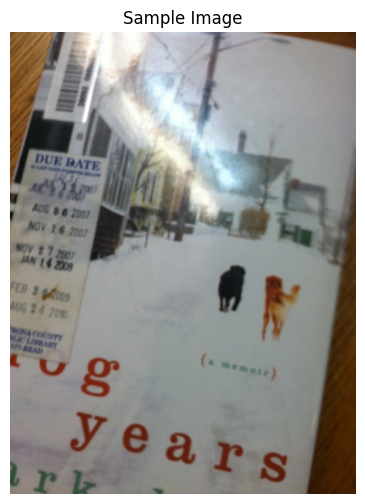

Generated caption by base model: USER:  
ASSISTANT: The book is titled "Dog Years" and is a memoir. It is written by a woman who shares her experiences with her dogs. The book is set in a small town, and the author reflects on her life and the impact of her dogs on her life. The book is a part of the public
Generated caption after fine-tning: USER:  
ASSISTANT: A book titled "A Dog Year" by W. Bruce Cameron is shown. The book is a memoir and is about a dog named Max. The book is due on December 14, 2007.
Actual Caption: a white paper showing an image of black and brown dog


In [ ]:
df = pd.read_csv(valid_csv)
file_n = df.iloc[10, :].file_name
sample_path = os.path.join(image_folder, file_n)
base_pred_caption = run_inference(base_model, processor, tokenizer, sample_path, device,64)
pred_caption = run_inference(model, processor, tokenizer, sample_path, device,64)
import matplotlib.pyplot as plt
img = Image.open(sample_path).convert("RGB")
# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()
print("Generated caption by base model:", base_pred_caption)
print("Generated caption after fine-tning:", pred_caption)
print("Actual Caption:", df.iloc[10, :].caption)

### Running inference on Random Test Images
The caption/description generated by the model is set to be of length 60-64

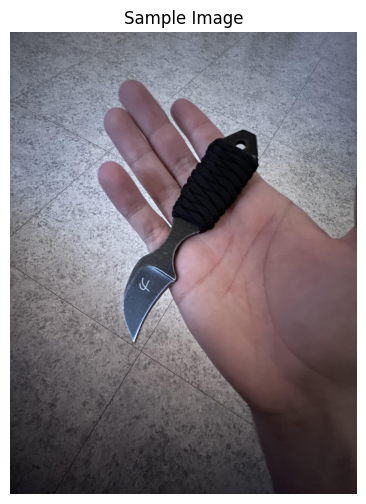

Generated caption by base model: USER:  
ASSISTANT: The image features a person holding a knife in their hand. The knife is positioned close to the person's fingers, and it appears to be a small pocket knife. The person's hand is holding the knife, and it seems to be a casual, everyday situation. The kn
Generated caption after fine-tning: USER:  
ASSISTANT: A person is holding a knife with a rope handle in their hand. The knife is positioned in the middle of the person's hand, and the rope handle is wrapped around their fingers. The person is standing on a tiled floor, which provides a contrasting background to the knife.


In [ ]:
sample_path = "/content/drive/MyDrive/EnigmaAI/dataset/images/knife_test.jpg"
base_pred_caption = run_inference(base_model, processor, tokenizer, sample_path, device,64)
pred_caption = run_inference(model, processor, tokenizer, sample_path, device,64)

img = Image.open(sample_path).convert("RGB")
# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()
print("Generated caption by base model:", base_pred_caption)
print("Generated caption after fine-tning:", pred_caption)

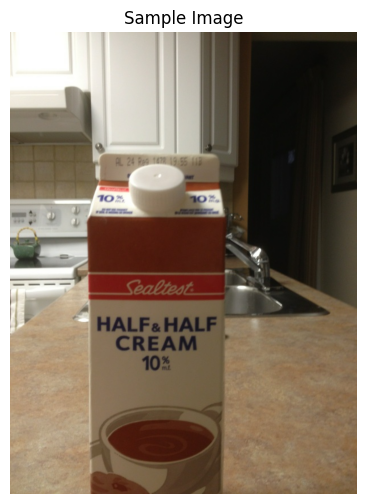

Generated caption by base model: USER:  
ASSISTANT: The image features a kitchen counter with a bottle of half-and-half cream sitting on it. The bottle is prominently displayed, occupying a significant portion of the counter space. The kitchen is equipped with a sink and an oven, which are located towards the right side of the counter
Generated caption after fine-tning: USER:  
ASSISTANT: The image features a kitchen with a white countertop and a red carton of half-and-half cream sitting on it. The carton is prominently displayed, occupying a significant portion of the counter. In the background, there is a sink and an oven, indicating a well-equipped


In [ ]:
sample_path = "/content/drive/MyDrive/EnigmaAI/dataset/images/test.jpg"
base_pred_caption = run_inference(base_model, processor, tokenizer, sample_path, device,64)
pred_caption = run_inference(model, processor, tokenizer, sample_path, device,64)

img = Image.open(sample_path).convert("RGB")
# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()
print("Generated caption by base model:", base_pred_caption)
print("Generated caption after fine-tning:", pred_caption)

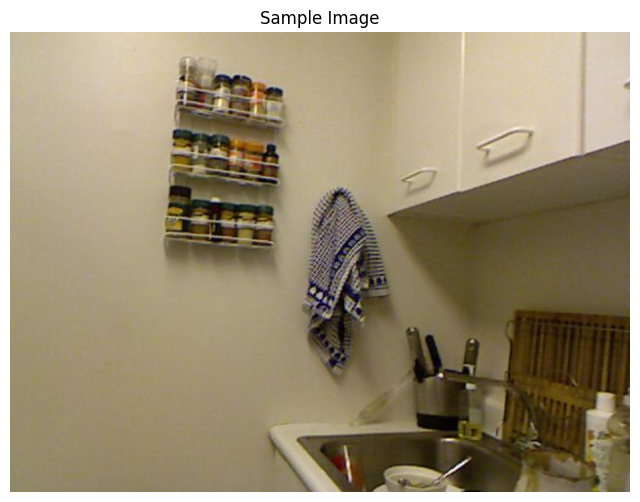

Generated caption by base model: USER:  
ASSISTANT: The image features a kitchen with a sink and a spice rack mounted on the wall. The spice rack is filled with various spices, and a towel is hanging nearby. The kitchen also has a dining table and a bowl placed on it. There are multiple bottles scattered around the
Generated caption after fine-tning: USER:  
ASSISTANT: The image depicts a kitchen with a white sink and a blue and white towel hanging on the wall. The kitchen is well-stocked with various spices and condiments, with numerous bottles and jars arranged on shelves and the countertop. There is also a bowl placed on


In [ ]:
sample_path = "/content/drive/MyDrive/EnigmaAI/dataset/images/test1.png"
base_pred_caption = run_inference(base_model, processor, tokenizer, sample_path, device,64)
pred_caption = run_inference(model, processor, tokenizer, sample_path, device,64)

img = Image.open(sample_path).convert("RGB")
# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()
print("Generated caption by base model:", base_pred_caption)
print("Generated caption after fine-tning:", pred_caption)

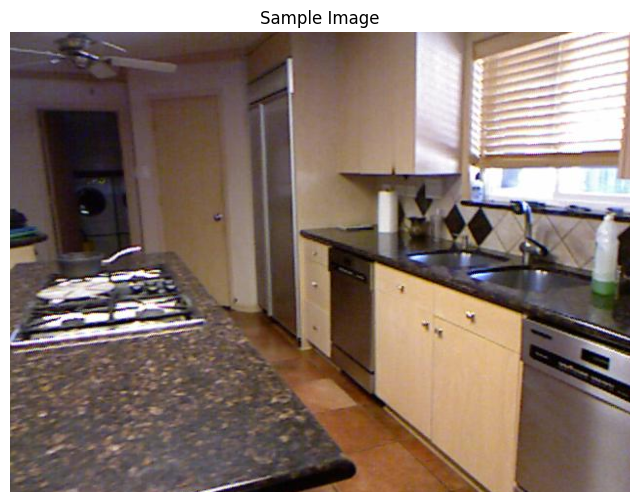

Generated caption by base model: USER:  
ASSISTANT: The image features a large kitchen with a variety of appliances and countertops. The kitchen is equipped with a stove, sink, and refrigerator. There are also two ovens, one located near the sink and the other closer to the refrigerator. The
Generated caption after fine-tning: USER:  
ASSISTANT: The image depicts a large kitchen with a marble countertop and various appliances. The kitchen features a stove top oven, a sink, a refrigerator, and a dishwasher. There are also two sinks, one near the center of the


In [ ]:
sample_path = "/content/drive/MyDrive/EnigmaAI/dataset/images/test2.png"
base_pred_caption = run_inference(base_model, processor, tokenizer, sample_path, device,60)
pred_caption = run_inference(model, processor, tokenizer, sample_path, device,60)

img = Image.open(sample_path).convert("RGB")
# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()
print("Generated caption by base model:", base_pred_caption)
print("Generated caption after fine-tning:", pred_caption)

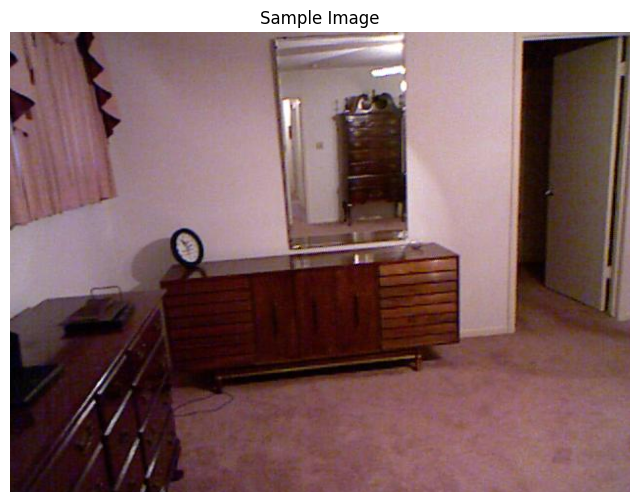

Generated caption by base model: USER:  
ASSISTANT: The image features a large wooden dresser with a mirror on top of it. The dresser is placed in a room with a carpeted floor. The room also contains a clock on the left side of the dresser and a vase on the right side. The overall setting appears to be a living room or
Generated caption after fine-tning: USER:  
ASSISTANT: The image features a large dresser with a mirror on the wall above it. The dresser is made of wood and has a brown color. The mirror is positioned above the dresser, reflecting the room's interior. The room is furnished with a bed, a clock, and a few books.


In [ ]:
sample_path = "/content/drive/MyDrive/EnigmaAI/dataset/images/test3.png"
base_pred_caption = run_inference(base_model, processor, tokenizer, sample_path, device, 64)
pred_caption = run_inference(model, processor, tokenizer, sample_path, device, 64)

img = Image.open(sample_path).convert("RGB")
# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()
print("Generated caption by base model:", base_pred_caption)
print("Generated caption after fine-tning:", pred_caption)

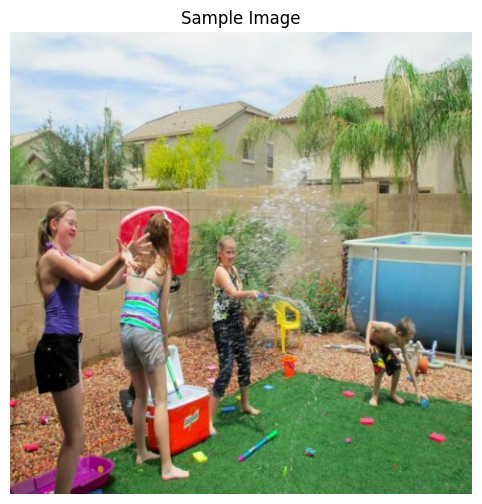

Generated caption by base model: USER:  
ASSISTANT: The image depicts a group of children playing in a backyard pool. They are enjoying themselves, with some of them standing in the water and others playing around the pool area. There are several children in the scene, with some closer to the pool and others further away.

In addition to the children
Generated caption after fine-tning: USER:  
ASSISTANT: The image depicts a group of children playing in a backyard with a sprinkler system. They are enjoying themselves, and there are several toys scattered around the yard. A few children are standing near a pool, while others are playing with a sprinkler. The scene is lively and full


In [ ]:
sample_path = "/content/drive/MyDrive/EnigmaAI/dataset/images/test4.jpg"
base_pred_caption = run_inference(base_model, processor, tokenizer, sample_path, device, 64)
pred_caption = run_inference(model, processor, tokenizer, sample_path, device, 64)

img = Image.open(sample_path).convert("RGB")
# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()
print("Generated caption by base model:", base_pred_caption)
print("Generated caption after fine-tning:", pred_caption)